# Imports

In [87]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
%load_ext autoreload
%autoreload 2
    
import os

import pandas as pd
import numpy as np
import seaborn as sns

from utils import CustomCleaner, get_submission_data
from scipy.stats import uniform

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold, \
    RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import TargetEncoder, MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.impute import SimpleImputer

from cuml.svm import SVC # Using this to select model, sklearn one for prediction, if best model

import warnings; warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'cuml'

# Load data

In [3]:
df = pd.read_csv(os.path.join('..', 'raw_data', 'train.csv'))
df.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,USA,29775006,AfricanAmerican,Male,[50-60),?,?,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days


# Data exploration

In [4]:
df.shape

(71236, 31)

In [5]:
df.isna().sum()

encounter_id                                 0
country                                      0
patient_id                                   0
race                                      3554
gender                                       0
age                                       3557
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3706
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2590
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_dia

## Categorical features

In [6]:
cat_cols = df.select_dtypes(exclude=np.number).columns.to_list()
cat_cols

['country',
 'race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'admission_type',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'glucose_test_result',
 'a1c_test_result',
 'change_in_meds_during_hospitalization',
 'prescribed_diabetes_meds',
 'medication',
 'readmitted_binary',
 'readmitted_multiclass']

In [7]:
df[cat_cols].isna().sum() / df.shape[0]

country                                  0.000000
race                                     0.049891
gender                                   0.000000
age                                      0.049933
weight                                   0.000000
payer_code                               0.000000
admission_type                           0.052024
medical_specialty                        0.000000
discharge_disposition                    0.036358
admission_source                         0.066231
primary_diagnosis                        0.000000
secondary_diagnosis                      0.000000
additional_diagnosis                     0.000000
glucose_test_result                      0.948228
a1c_test_result                          0.832725
change_in_meds_during_hospitalization    0.000000
prescribed_diabetes_meds                 0.000000
medication                               0.000000
readmitted_binary                        0.000000
readmitted_multiclass                    0.000000


### Country

<font color="red" size=3> Only one value, drop.

In [8]:
df.country.unique()

array(['USA'], dtype=object)

### Race

<font color="red" size=3> Value '?' == nan; deal with nans.

In [9]:
df.race.unique()

array(['Caucasian', 'AfricanAmerican', 'Other', nan, 'Hispanic', 'Asian',
       '?'], dtype=object)

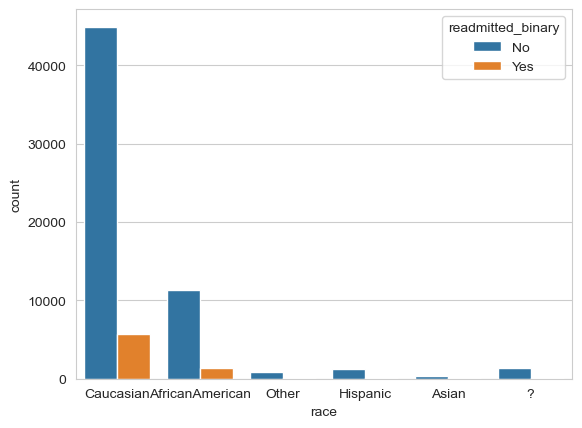

In [10]:
sns.countplot(x='race', data=df, hue='readmitted_binary');

### Gender

<font color="red" size=3>Deal with 'Unknown/Invalid'

In [11]:
df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

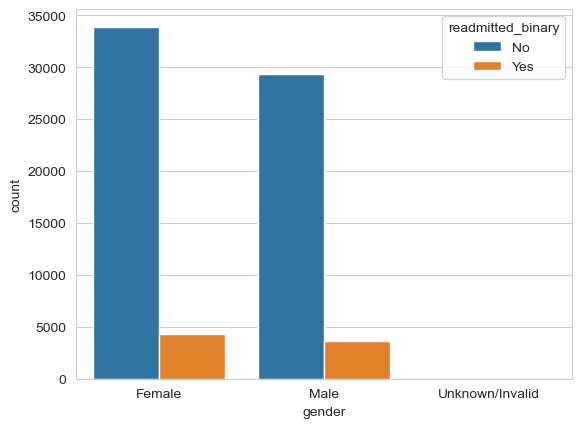

In [12]:
sns.countplot(x='gender', hue='readmitted_binary', data=df);

In [13]:
df.gender.value_counts()

gender
Female             38228
Male               33005
Unknown/Invalid        3
Name: count, dtype: int64

### Age

<font color="red" size=3>Deal with nan; turn into numeric

In [14]:
df.age.unique()

array(['[70-80)', '[50-60)', '[60-70)', '[80-90)', nan, '[40-50)',
       '[20-30)', '[30-40)', '[90-100)', '[10-20)', '[0-10)'],
      dtype=object)

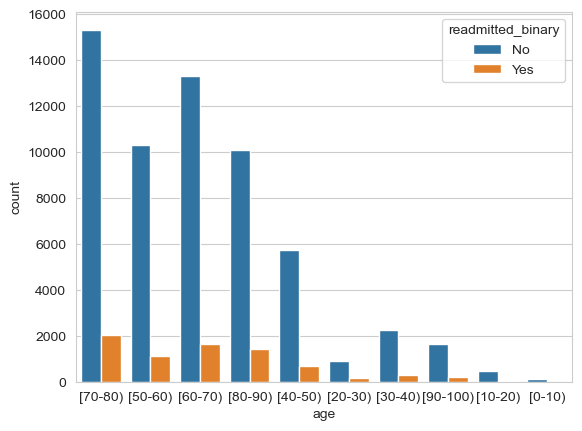

In [15]:
sns.countplot(x='age', hue='readmitted_binary', data=df);

### Weight

<font color="red" size=3>97% of "?", which are nan. DROP

In [16]:
df.weight.unique()

array(['?', '[50-75)', '[100-125)', '[75-100)', '[125-150)', '[25-50)',
       '>200', '[0-25)', '[150-175)', '[175-200)'], dtype=object)

In [17]:
df.weight.value_counts() / df.shape[0]

weight
?            0.968471
[75-100)     0.013097
[50-75)      0.008928
[100-125)    0.006303
[125-150)    0.001348
[25-50)      0.000941
[0-25)       0.000491
[150-175)    0.000295
[175-200)    0.000098
>200         0.000028
Name: count, dtype: float64

### Payer code

<font color="red" size=3>"?" are nan. Are they true nan, or they mean "no insurance"? Try both approaches.

In [18]:
df.payer_code.unique()

array(['?', 'MC', 'HM', 'UN', 'SP', 'SI', 'CM', 'DM', 'CP', 'MD', 'OG',
       'BC', 'PO', 'WC', 'OT', 'MP', 'CH', 'FR'], dtype=object)

In [19]:
df.payer_code.value_counts() / df.shape[0]

payer_code
?     0.395881
MC    0.318420
HM    0.060629
SP    0.049708
BC    0.046213
MD    0.034870
CP    0.024735
UN    0.024328
CM    0.018909
OG    0.010234
PO    0.005685
DM    0.005306
CH    0.001432
WC    0.001390
OT    0.000856
MP    0.000758
SI    0.000632
FR    0.000014
Name: count, dtype: float64

### Admission type

<font color="red" size=3>Impute nan; Discretize even more the data (get fewer categories)

In [20]:
df.admission_type.unique()

array(['Emergency', nan, 'Elective', 'Urgent', 'Not Available', 'Newborn',
       'Not Mapped', 'Trauma Center'], dtype=object)

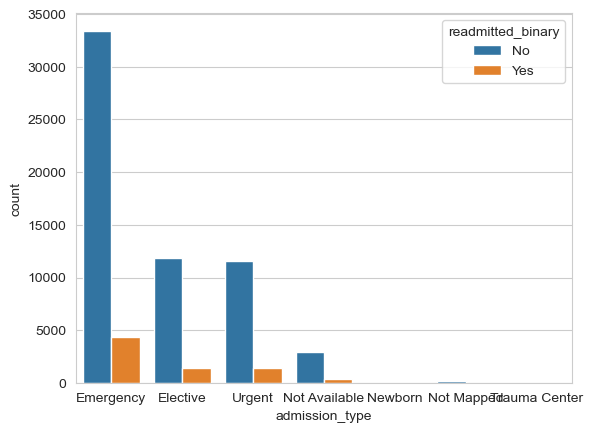

In [21]:
sns.countplot(x='admission_type', hue='readmitted_binary', data=df);

### Medical specialty

<font color="red" size=3>"?" are nan; Impute nan (50%); Discretize even more or drop?

In [22]:
df.medical_specialty.unique()

array(['Family/GeneralPractice', '?', 'InternalMedicine',
       'Surgery-General', 'Radiologist', 'Emergency/Trauma', 'Hematology',
       'Nephrology', 'Orthopedics', 'ObstetricsandGynecology',
       'Psychiatry', 'Cardiology', 'Gastroenterology', 'Psychology',
       'Surgery-Thoracic', 'Orthopedics-Reconstructive',
       'Surgery-Vascular', 'PhysicianNotFound', 'Neurology',
       'PhysicalMedicineandRehabilitation', 'Pulmonology',
       'Hematology/Oncology', 'Oncology', 'Surgery-Neuro', 'Radiology',
       'Urology', 'Pediatrics', 'Surgery-Cardiovascular/Thoracic',
       'Gynecology', 'Pediatrics-Endocrinology', 'Surgery-Maxillofacial',
       'Podiatry', 'Ophthalmology', 'Endocrinology', 'Obstetrics',
       'Pediatrics-CriticalCare', 'Otolaryngology',
       'Pediatrics-Neurology', 'Surgery-Cardiovascular', 'Hospitalist',
       'Surgery-Plastic', 'Osteopath', 'Pediatrics-Pulmonology',
       'SurgicalSpecialty', 'InfectiousDiseases', 'AllergyandImmunology',
       'Surgeon

In [23]:
df.medical_specialty.value_counts() / df.shape[0]

medical_specialty
?                                0.490230
InternalMedicine                 0.144478
Emergency/Trauma                 0.074667
Family/GeneralPractice           0.073235
Cardiology                       0.052165
                                   ...   
Speech                           0.000014
SportsMedicine                   0.000014
Pediatrics-InfectiousDiseases    0.000014
Proctology                       0.000014
Neurophysiology                  0.000014
Name: count, Length: 69, dtype: float64

### Discharge disposition

<font color="red" size=3>Impute nans; Discretize even more

In [24]:
df.discharge_disposition.unique()

array(['Discharged to home',
       'Discharged/transferred to a federal health care facility.',
       'Discharged/transferred to home with home health service',
       'Discharged/transferred to SNF', 'Hospice / medical facility', nan,
       'Discharged/transferred to another short term hospital',
       'Discharged/transferred to ICF', 'Expired',
       'Discharged/transferred to another type of inpatient care institution',
       'Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'Discharged/transferred to a long term care hospital.', 'Left AMA',
       'Hospice / home',
       'Discharged/transferred to home under care of Home IV provider',
       'Not Mapped',
       'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
       'Discharged/transferred within this institution to Medicare approved swing bed',
       'Discharged/transferred to a nursing facility certified under Medicaid b

In [25]:
df.discharge_disposition.value_counts()

discharge_disposition
Discharged to home                                                                                           42256
Discharged/transferred to SNF                                                                                 9780
Discharged/transferred to home with home health service                                                       9005
Discharged/transferred to another short term hospital                                                         1488
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1393
Expired                                                                                                       1135
Discharged/transferred to another type of inpatient care institution                                           822
Not Mapped                                                                                                     679
Discharged/transferred to ICF                             

### Admission source

<font color="red" size=3>Impute nans; Discretize even more

In [26]:
df.admission_source.unique()

array([' Emergency Room', 'Clinic Referral', nan,
       ' Transfer from another health care facility',
       ' Physician Referral', 'Transfer from a hospital', 'HMO Referral',
       ' Transfer from a Skilled Nursing Facility (SNF)', ' Not Mapped',
       ' Not Available', ' Court/Law Enforcement',
       ' Transfer from hospital inpt/same fac reslt in a sep claim',
       ' Transfer from critial access hospital', ' Extramural Birth',
       'Normal Delivery', ' Transfer from Ambulatory Surgery Center',
       ' Sick Baby'], dtype=object)

In [27]:
df.admission_source.value_counts()

admission_source
 Emergency Room                                               40319
 Physician Referral                                           20678
Transfer from a hospital                                       2230
 Transfer from another health care facility                    1562
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 595
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   88
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                

### Primary, secondary, additional diagnoses

<font color="red" size=3>Discretize even more

In [28]:
df.primary_diagnosis.nunique()

687

In [29]:
df.secondary_diagnosis.nunique()

699

In [30]:
df.additional_diagnosis.nunique()

747

### Glucose test result

<font color="red" size=3>95% nan; DROP

In [31]:
df.glucose_test_result.unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

### a1c test result

<font color="red" size=3>83% nan; DROP

In [32]:
df.a1c_test_result.unique()

array([nan, 'Norm', '>8', '>7'], dtype=object)

### Change in meds during hospitalization

<font color="red" size=3>Clean

In [33]:
df.change_in_meds_during_hospitalization.unique()

array(['No', 'Ch'], dtype=object)

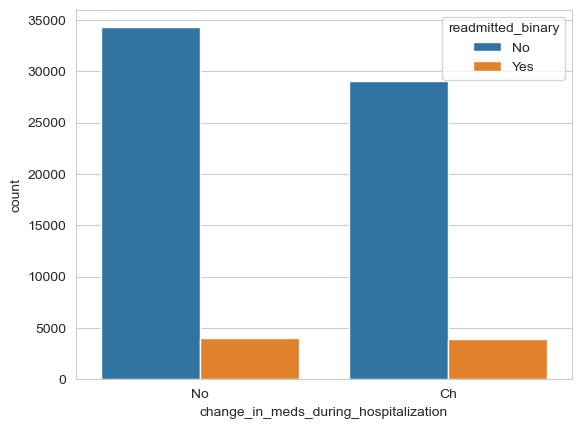

In [34]:
sns.countplot(x='change_in_meds_during_hospitalization', hue='readmitted_binary', data=df);

### Prescribed diabetes meds

<font color="red" size=3>Clean

In [35]:
df.prescribed_diabetes_meds.unique()

array(['No', 'Yes'], dtype=object)

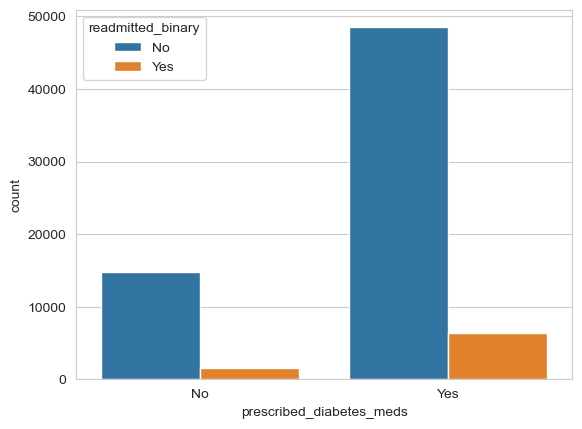

In [36]:
sns.countplot(x='prescribed_diabetes_meds', hue='readmitted_binary', data=df);

### Medication

<font color="red" size=3>Extract medication names from list.

In [37]:
df.medication.nunique()

303

In [38]:
for n in range(5):
    print(df.medication[n])

[]
['insulin']
['glimepiride', 'insulin']
[]
[]


## Numerical features

In [39]:
num_cols = df.select_dtypes(include=np.number).columns.to_list()
num_cols

['encounter_id',
 'patient_id',
 'outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses']

In [40]:
df[num_cols].isna().sum() / df.shape[0]

encounter_id                          0.0
patient_id                            0.0
outpatient_visits_in_previous_year    0.0
emergency_visits_in_previous_year     0.0
inpatient_visits_in_previous_year     0.0
average_pulse_bpm                     0.0
length_of_stay_in_hospital            0.0
number_lab_tests                      0.0
non_lab_procedures                    0.0
number_of_medications                 0.0
number_diagnoses                      0.0
dtype: float64

In [41]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
encounter_id,71236.0,5.487986e+05,2.597047e+05,100000.0,323118.50,548370.0,774058.50,999980.0
patient_id,71236.0,5.430228e+07,3.879585e+07,135.0,23396510.25,45305631.0,87558374.25,189502619.0
outpatient_visits_in_previous_year,71236.0,3.695884e-01,1.287469e+00,0.0,0.00,0.0,0.00,42.0
emergency_visits_in_previous_year,71236.0,1.962491e-01,9.108537e-01,0.0,0.00,0.0,0.00,76.0
inpatient_visits_in_previous_year,71236.0,6.401539e-01,1.267271e+00,0.0,0.00,0.0,1.00,21.0
average_pulse_bpm,71236.0,9.961122e+01,2.304052e+01,60.0,80.00,100.0,119.00,139.0
length_of_stay_in_hospital,71236.0,4.391024e+00,2.988739e+00,1.0,2.00,4.0,6.00,14.0
number_lab_tests,71236.0,4.309565e+01,1.964292e+01,1.0,31.00,44.0,57.00,121.0
non_lab_procedures,71236.0,1.340923e+00,1.706664e+00,0.0,0.00,1.0,2.00,6.0
number_of_medications,71236.0,1.599545e+01,8.122347e+00,1.0,10.00,15.0,20.00,75.0


### Outpatient, inpatient, emergency visits in previous year

<font color="red" size=3>All 3 have similar distrubutions. Very skewed, long right tail. Maybe normalize somehow? Or engineer into something else.

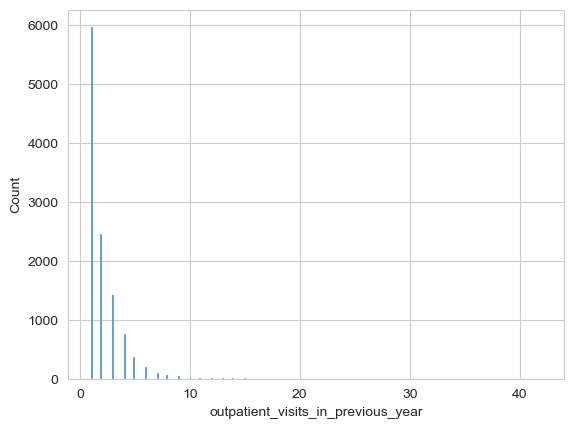

In [42]:
sns.histplot(x='outpatient_visits_in_previous_year', data=df[df.outpatient_visits_in_previous_year>0]);

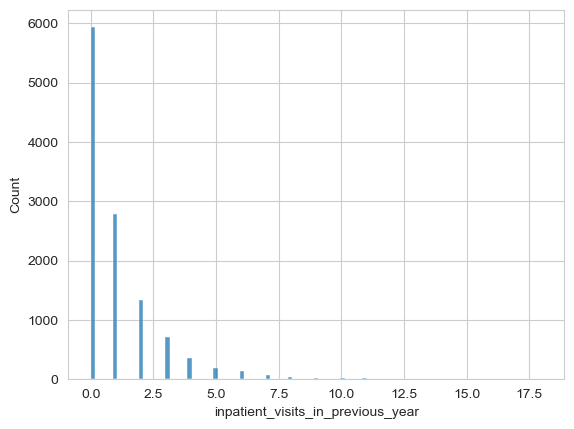

In [43]:
sns.histplot(x='inpatient_visits_in_previous_year', data=df[df.outpatient_visits_in_previous_year>0]);

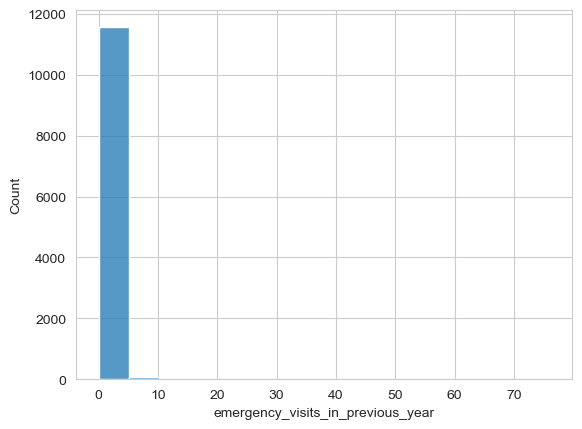

In [44]:
sns.histplot(x='emergency_visits_in_previous_year', data=df[df.outpatient_visits_in_previous_year>0]);

### Average pulse bpm

<font color="red" size=3>Clean

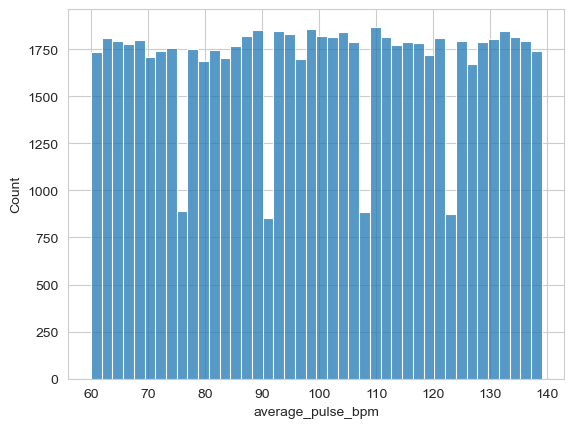

In [45]:
sns.histplot(x='average_pulse_bpm', data=df);

### Length of stay in hospital

<font color="red" size=3>Outliers > 13, by IQR definition

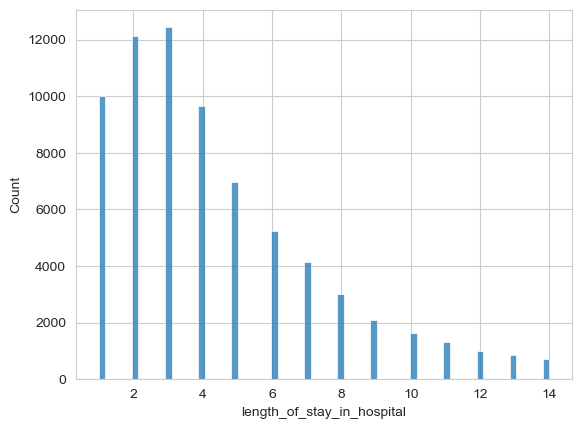

In [46]:
sns.histplot(x='length_of_stay_in_hospital', data=df);

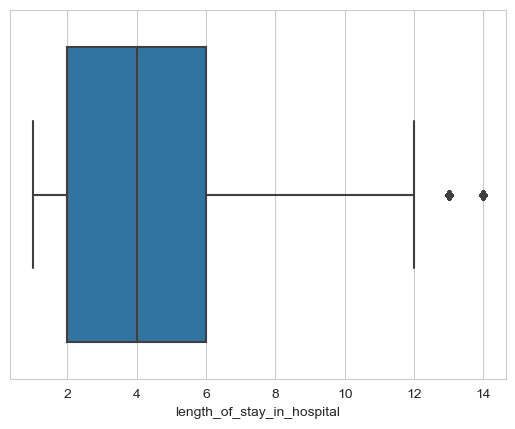

In [47]:
sns.boxplot(x='length_of_stay_in_hospital', data=df);

### Number lab tests

<font color="red" size=3>Outliers > 100

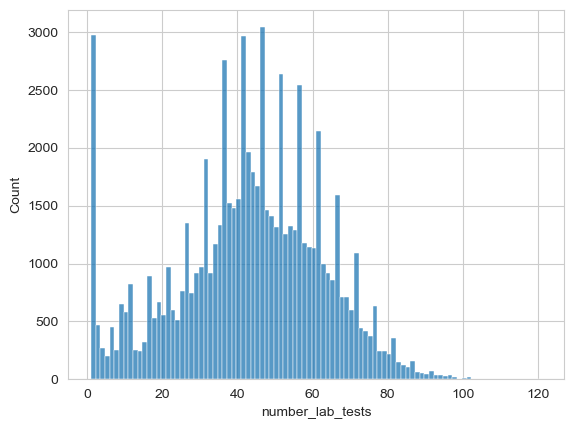

In [48]:
sns.histplot(x='number_lab_tests', data=df);

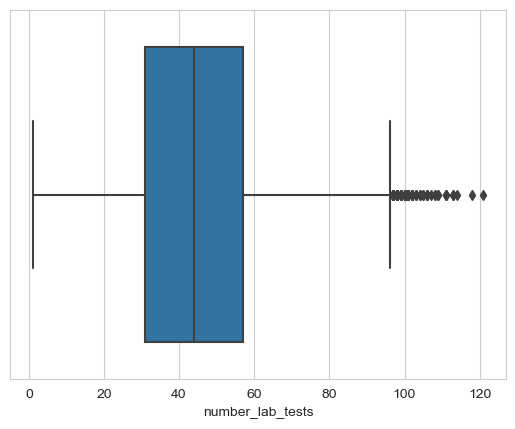

In [49]:
sns.boxplot(x='number_lab_tests', data=df);

### Non lab procedures

<font color="red" size=3>Clean; 6 could be outliers, but there are more than 5.

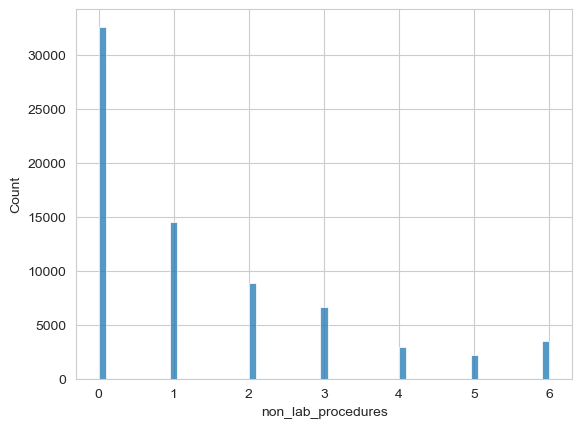

In [50]:
sns.histplot(x='non_lab_procedures', data=df);

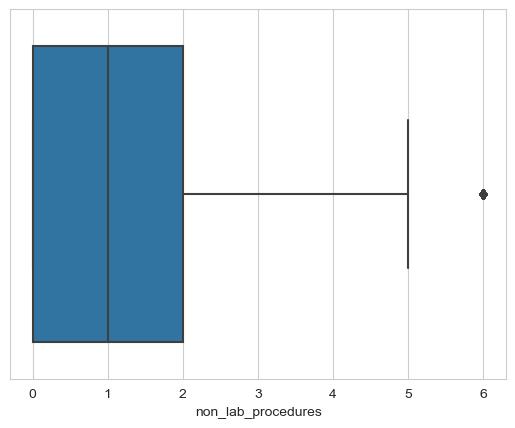

In [51]:
sns.boxplot(x='non_lab_procedures', data=df);

In [52]:
df.non_lab_procedures.value_counts().sort_index() / df.shape[0]

non_lab_procedures
0    0.458083
1    0.204012
2    0.124881
3    0.092846
4    0.041103
5    0.030252
6    0.048824
Name: count, dtype: float64

### Number of medications

<font color="red" size=3>Outliers > 50

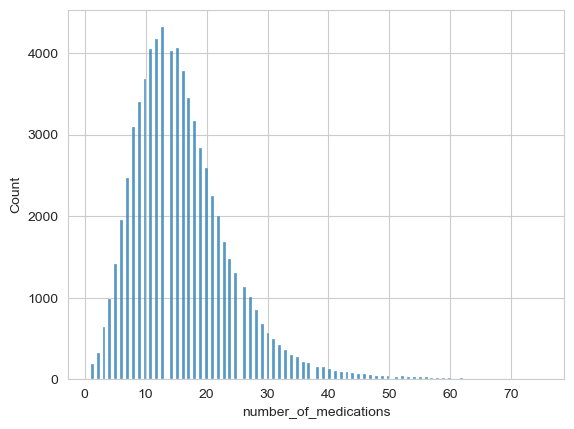

In [53]:
sns.histplot(x='number_of_medications', data=df);

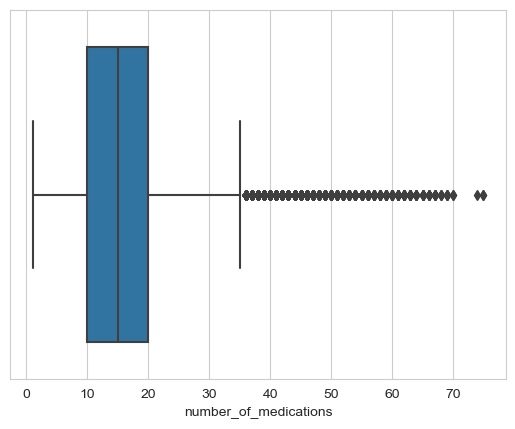

In [54]:
sns.boxplot(x='number_of_medications', data=df);

### Number diagnoses

<font color="red" size=3>Outliers > 9. There's a clear threshold on 9

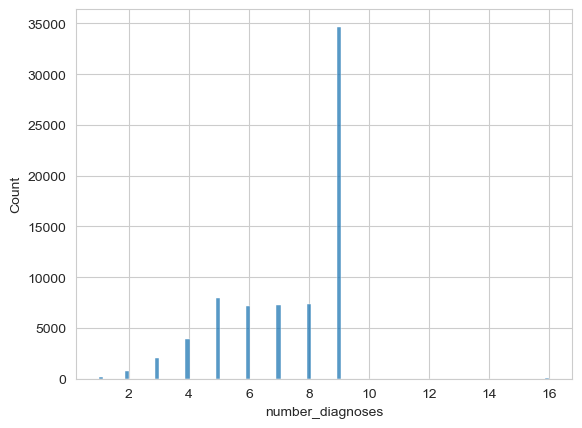

In [55]:
sns.histplot(x='number_diagnoses', data=df);

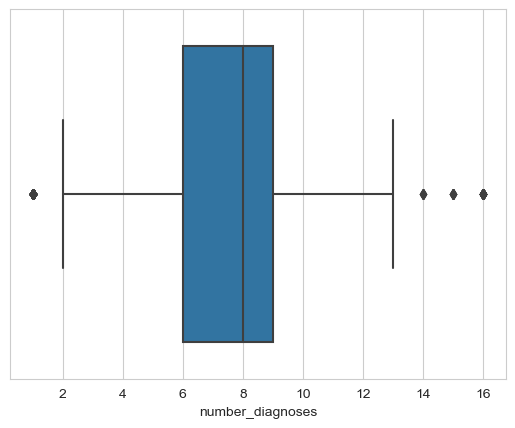

In [56]:
sns.boxplot(x='number_diagnoses', data=df);

# Preprocess

## Outlier removal

<font color="red" size=3>97% of original data kept after outlier removal.

In [57]:
filters = (df.length_of_stay_in_hospital < 13) & \
          (df.number_lab_tests < 100) & \
          (df.number_of_medications < 50) & \
          (df.number_diagnoses <=9)

df[filters].shape

(69250, 31)

In [58]:
df[filters].shape[0] / df.shape[0]

0.9721208377786512

In [59]:
df[filters].to_csv(os.path.join('..', 'clean_data', 'outliers.csv')) # Save to use later

## Preprocessing

In this section, the whole preprocessing and feature engineering was summarized into a CustomCleaner class, in a separated utils.py module, taking advantage of the sklearn.base classes "TransformerMixin" and "BaseEstimator".

This way, our custom class has access to .fit and .transform methods, ensuring that whatever transformation we apply on the training set will be replicated in the test set and that any change in the transformations or new features addition can be easily done in an isolated way.

The specifics of the transformations are documented in the CustomCleaner docstring.

In [60]:
cleaner = CustomCleaner()
print(cleaner.__doc__)

None


In [61]:
# Using the df with outlier removal
df = pd.read_csv(os.path.join('..', 'clean_data', 'outliers.csv'), index_col=0)
df.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,USA,70110,Caucasian,Female,[70-80),?,?,0,0,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
2,634063,USA,80729253,Caucasian,Female,[60-70),?,?,0,0,...,135,250,6,NaN,NaN,Ch,Yes,"['glimepiride', 'insulin']",No,No
3,890610,USA,2919042,AfricanAmerican,Male,[60-70),?,MC,0,0,...,562,455,5,NaN,NaN,No,No,[],No,No
4,654194,USA,84871971,Caucasian,Female,[70-80),?,HM,1,0,...,599,428,9,NaN,NaN,No,No,[],No,>30 days
5,269878,USA,279288,Caucasian,Female,[50-60),?,?,0,0,...,250,244,3,NaN,Norm,No,No,[],No,>30 days


In [62]:
df_clean = df.copy()
df_clean = cleaner.fit_transform(df_clean)
df_clean.head()

,encounter_id,country,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,...,pioglitazone,repaglinide,tolbutamide,number_diab_meds,number_visits_per_patient,n_medication_per_day,n_lab_tests_per_day,prop_inpatient,prop_outpatient,prop_emergency
0,533253,USA,70110,Caucasian,Female,75.0,NaN,False,0,0,...,False,False,False,0,6,2.302585,3.178054,0.333333,0.0,0.0
2,634063,USA,80729253,Caucasian,Female,65.0,NaN,False,0,0,...,False,False,False,2,1,1.299283,2.302585,1.000000,0.0,0.0
3,890610,USA,2919042,AfricanAmerican,Male,65.0,NaN,True,0,0,...,False,False,False,0,1,0.405465,2.079442,1.000000,0.0,0.0
4,654194,USA,84871971,Caucasian,Female,75.0,NaN,True,1,0,...,False,False,False,0,2,0.916291,2.058388,0.000000,0.5,0.0
5,269878,USA,279288,Caucasian,Female,55.0,NaN,False,0,0,...,False,False,False,0,1,1.203973,2.961831,0.000000,0.0,0.0


In [63]:
# Drop unwanted columns
df_clean = df_clean.drop(columns=['country', 'weight', 'glucose_test_result', 'a1c_test_result'])

In [64]:
df_clean.shape

(69250, 54)

### Train test split

In [65]:
num_cols = df_clean.select_dtypes(include=np.number).drop(columns=['encounter_id', 'patient_id']).columns.to_list()

In [66]:
cat_cols = df_clean.select_dtypes(exclude=np.number).drop(columns=['readmitted_binary', 'readmitted_multiclass']).columns

In [67]:
X = df_clean.drop(columns=['readmitted_binary', 'readmitted_multiclass', 'encounter_id', 'patient_id'])
y = df_clean.readmitted_binary

label = LabelEncoder()
y = label.fit_transform(y)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Preprocessing

In [69]:
cat_pipe = Pipeline([
    ('encoder', TargetEncoder(target_type='binary'))
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('transformer', PowerTransformer()),
    ('scaler', MinMaxScaler())
])

preproc_pipe = ColumnTransformer([
    ('cat', cat_pipe, cat_cols),
    ('num', num_pipe, num_cols)
], remainder='drop')

preproc_pipe

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  TargetEncoder(target_type='binary'))]),
                                 Index(['race', 'gender', 'payer_code', 'admission_type', 'medical_specialty',
       'discharge_disposition', 'admission_source', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_med...
                                  'emergency_visits_in_previous_year',
                                  'inpatient_visits_in_previous_year',
                                  'average_pulse_bpm',
                                  'length_of_stay_in_hospital',
                                  'number_lab_tests', 'non_lab_procedures',
                                  'number_of_medications', 'number_diagnoses',
                                  'number_diab_meds',
                                  'number_visits_per_patient',
                                  'n_medication_per_day', 'n_lab_tests_per_day',
                                  'prop_inpatient', 'prop_outpatient',
                                  'prop_emergency'])])

In [70]:
X_train = np.float32(preproc_pipe.fit_transform(X_train, y_train))
X_test = np.float32(preproc_pipe.transform(X_test))

# Model evaluation

In [88]:
model_scores = {}
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv_score = cross_val_score(model, scoring="f1", cv=cv, X=X_test, y=y_test)
    return model.__class__.__name__, cv_score.mean(), cv_score.std()

models_to_evaluate = [
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=42),
    SGDClassifier(n_jobs=-1, random_state=42, class_weight='balanced', early_stopping=True),
    AdaBoostClassifier(n_estimators=100, random_state=42),
    RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42),
]

for model in models_to_evaluate:
    print(f"Evaluating {model.__class__.__name__}")
    model_name, mean_score, std_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    model_scores[model_name] = (mean_score, std_score)

Evaluating KNeighborsClassifier
Evaluating DecisionTreeClassifier
Evaluating SGDClassifier
Evaluating AdaBoostClassifier
Evaluating RandomForestClassifier
Evaluating GaussianNB
Evaluating GradientBoostingClassifier


In [89]:
model_scores

{'KNeighborsClassifier': (0.09463216300461338, 0.024450606732653566),
 'DecisionTreeClassifier': (0.19828855692277833, 0.02794188346490853),
 'SGDClassifier': (0.2540155833760787, 0.051066979481993825),
 'AdaBoostClassifier': (0.05654442461793501, 0.021512866903989642),
 'RandomForestClassifier': (0.016940373134222322, 0.010855105239481074),
 'GaussianNB': (0.2505349233545452, 0.030895696729937965),
 'GradientBoostingClassifier': (0.04204083090501214, 0.017375309747168017)}

### Model selection

In [90]:
model = SGDClassifier(n_jobs=-1, class_weight='balanced', early_stopping=True)

In [100]:
rand_params = {
    'loss': ['hinge', 'log_loss', 'squared_hinge', 'perceptron', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'l1_ratio': uniform(0, 1),
    'alpha': uniform(0.00001, 1),
    'learning_rate': ['optimal', 'invscaling', 'adaptive', 'constant'],
    'eta0': uniform(0, 1),
    'epsilon': uniform(0, 1),
    'power_t': uniform(-1, 1)
}

In [101]:
rand_search = RandomizedSearchCV(model, rand_params, n_iter=500, scoring='f1', cv=5, n_jobs=-1, verbose=1)
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(class_weight='balanced',
                                           early_stopping=True, n_jobs=-1),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x149f86f10>,
                                        'epsilon': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14994edd0>,
                                        'eta0': <scipy.stats._distn_infrastr...
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x149f84d10>,
                                        'learning_rate': ['optimal',
                                                          'invscaling',
                                                          'adaptive',
                                                          'constant'],
                                        'loss': ['hinge', 'log_loss',
                                                 'squared_hinge', 'perceptron',
                                                 'modified_huber'],
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'power_t': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x149e2c590>},
                   scoring='f1', verbose=1)

In [102]:
rand_search.best_params_

{'alpha': 0.9948911121582883,
 'epsilon': 0.9660495900830656,
 'eta0': 0.20409238118536022,
 'l1_ratio': 0.510430552639985,
 'learning_rate': 'adaptive',
 'loss': 'hinge',
 'penalty': None,
 'power_t': -0.9834888369491211}

In [103]:
rand_search.best_score_

0.31747168974508133

In [118]:
# y_pred_sgd = rand_search.predict(X_test)
# f1_score(y_test, y_pred_sgd)
# rand_search.best_estimator_.coef_
df_coef = pd.DataFrame(rand_search.best_estimator_.coef_, columns=X.columns)

0    13.108746
dtype: float32

### SVC

In [ ]:
model_svc = SVC(class_weight='balanced')

In [ ]:
rand_params_svc = {
    'C': uniform(0.0001, 5),
    'kernel': ['poly', 'rbf', 'linear', 'sigmoid'],
    'degree': [2, 3, 4, 5, 6],
    'gamma': ['auto', 'scale'],
    'coef0': uniform(0, 1)
}

In [ ]:
rand_search_svc = RandomizedSearchCV(model_svc, rand_params_svc, n_iter=500, scoring='f1', cv=5, n_jobs=-1, verbose=1)
rand_search_svc.fit(X_train, y_train)

In [ ]:
rand_search_svc.best_params_

In [ ]:
rand_search_svc.best_score_

In [ ]:
y_pred_svc = rand_search_svc.predict(X_test)
f1_score(y_test, y_pred_svc)

### Predict to submit

In [ ]:
X_sub = preproc_pipe.fit_transform(X, y)

In [ ]:
best_model = rand_search.best_estimator_
best_model.fit(X_sub, y)

In [ ]:
submission_df = pd.read_csv(os.path.join('..', 'raw_data', 'test.csv'))

In [ ]:
sub_encounter_id = submission_df.encounter_id
sub_clean = cleaner.transform(submission_df)
sub_preproc = preproc_pipe.transform(sub_clean)

In [ ]:
get_submission_data(best_model, sub_preproc, sub_encounter_id, '../submissions/')